# Tutorial Assignment 3

In [1]:
import os

import common
import gensim  # word2vec (very similar to our product2vec model)
import matplotlib  # plot final map
import numpy as np
import p2vmap
import pandas as pd
import sklearn.manifold  # t-SNE (last step of p2v-map)
import torch  # NN -> our own P2V model
import torch.nn
import torch.nn.functional

matplotlib.rcParams["image.cmap"] = "jet"

## Input

In [2]:
# the path that contains the data
path = os.path.expandvars("~/Dropbox/teaching/big-data/data/dr-g/upload")

In [3]:
# Not known in reality!
# In reality we typically have access to the retailer's categories, but not the real categories
product = pd.DataFrame(
    {
        "product": list(range(300)),
        "category": np.repeat(range(20), 15),
    }
)

<br>
<br>

## Load configs and data

In [4]:
config_w2v = common.read_yaml("config-w2v.yaml")
config_w2v

{'baskets_df_to_list': {'min_basket_size': 3,
  'shuffle': True,
  'to_string': True,
  'seed': 123},
 'Word2Vec': {'vector_size': 25,
  'window': 1000,
  'min_count': 1,
  'alpha': 0.025,
  'min_alpha': 0.0001,
  'sample': 0.001,
  'sg': 1,
  'negative': 10,
  'epochs': 3},
 'TSNE': {'n_components': 2,
  'n_iter': 4000,
  'perplexity': 5,
  'init': 'pca',
  'angle': 0.5,
  'random_state': 123,
  'verbose': 0}}

In [5]:
config_p2vmap = common.read_yaml("config-p2vmap.yaml")
config_p2vmap

{'trainer': {'epochs': 10},
 'p2v': {'size': 25},
 'data': {'data_streamer': {'variable_basket': 'basket',
   'variable_product': 'product',
   'batch_size': 8192,
   'n_negative_samples': 10,
   'power': 0.75,
   'shuffle': False,
   'allow_context_collisions': False},
  'split': {'test_size': 0.05},
  'train': {'batch_size': 1024, 'shuffle': True, 'drop_last': True},
  'valid': {'batch_size': 4096, 'shuffle': False, 'drop_last': False},
  'test': {'batch_size': 4096, 'shuffle': False, 'drop_last': False}}}

In [6]:
baskets = pd.read_parquet(f"{path}/market-baskets.parquet")
del baskets["customer"]
baskets.head()

,product,basket
0,51,00000000
1,113,00000000
2,154,00000000
3,165,00000000
4,185,00000000


<br>
<br>

## P2V-MAP based on `gensim`

### Produce basket list

In [7]:
baskets.head()

,product,basket
0,51,00000000
1,113,00000000
2,154,00000000
3,165,00000000
4,185,00000000


In [8]:
config_w2v["baskets_df_to_list"]

{'min_basket_size': 3, 'shuffle': True, 'to_string': True, 'seed': 123}

In [9]:
# we only keep the first 1M rows
basket_list = p2vmap.baskets_df_to_list(
    x=baskets.head(1_000_000), **config_w2v["baskets_df_to_list"]
)
basket_list[:2]

[['198', '219', '102', '136', '191', '228', '174', '32', '162', '4', '270'],
 ['159', '106', '19', '136']]

In [10]:
# less than 1M purchases, we skip baskets with less than 3 products
sum([len(b) for b in basket_list])

990932

In [11]:
# number of baskets
len(basket_list)

156778

### Word2Vec model

In [12]:
# p2v: which products (co-)occur in a shopping basket
# w2v: which words (co-)occur in a sentence
#
# this sentence is "which products (co-)occur in a shopping basket."
# ------------------- x ------------------------
#                   window
#
# we set window to a very large number to always use all products in a basket
w2v = gensim.models.Word2Vec(basket_list, **config_w2v["Word2Vec"])

In [13]:
config_w2v["Word2Vec"]
# vector size

{'vector_size': 25,
 'window': 1000,
 'min_count': 1,
 'alpha': 0.025,
 'min_alpha': 0.0001,
 'sample': 0.001,
 'sg': 1,
 'negative': 10,
 'epochs': 3}

In [14]:
product_embedding, _, _ = p2vmap.gensim_to_pandas(w2v)
product_embedding.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
product,,,,,,,,,,,,,,,,,,,,,
0,0.698184,-0.267109,-0.268259,-0.283699,-0.035170,-0.320666,0.004873,0.440573,-0.025418,-0.042116,...,0.356835,0.071930,-0.084184,0.124781,0.111691,0.685301,-0.684012,0.772679,-0.358692,-0.049835
1,0.594313,-0.304166,-0.276320,-0.314553,-0.147924,-0.308384,-0.049042,0.394323,-0.033204,-0.073849,...,0.251013,-0.056435,-0.208138,-0.001414,0.105168,0.758121,-0.609367,0.739802,-0.423855,0.009249
2,0.702221,-0.348003,-0.305340,-0.328762,0.071340,-0.252438,-0.040859,0.404687,0.004226,-0.094069,...,0.312105,0.129227,-0.130776,0.132844,0.156041,0.724814,-0.625681,0.732117,-0.413212,0.089795
3,0.644117,-0.319973,-0.315047,-0.232838,-0.161784,-0.314351,-0.089541,0.456876,-0.116067,-0.243799,...,0.127563,0.005860,-0.164511,0.029503,0.094170,0.810089,-0.649962,0.722354,-0.433333,-0.029080
4,0.724029,-0.212491,-0.327331,-0.276322,-0.081711,-0.328879,0.005359,0.396139,-0.018593,-0.056015,...,0.318120,0.116433,-0.127541,0.083842,0.189018,0.718072,-0.651779,0.824390,-0.384247,-0.037491


In [15]:
# each row is a product vector
x = product_embedding.values
# normalize vectors to unit-length
x /= np.linalg.norm(x, axis=1)[:, np.newaxis]

In [16]:
# cosine similarity of product 0 with itself
x[0, :].dot(x[0, :])

1.0

In [17]:
# cosine similarities between the first 5 products
x[0:5, :].dot(x[0:5, :].T)

array([[0.99999994, 0.98062825, 0.98673004, 0.9706218 , 0.9949092 ],
       [0.98062825, 1.        , 0.97305375, 0.9855621 , 0.9825565 ],
       [0.98673004, 0.97305375, 1.        , 0.9652598 , 0.9849684 ],
       [0.9706218 , 0.9855621 , 0.9652598 , 0.99999994, 0.9742485 ],
       [0.9949092 , 0.9825565 , 0.9849684 , 0.9742485 , 1.        ]],
      dtype=float32)

In [18]:
# cosine similarities between products 10 to 19. note:
# - 10-14 and 15-19 are each very similar
# - 10-14 are not similar to 15-19
np.round(x[10:20, :].dot(x[10:20, :].T), 2)

array([[1.  , 0.98, 0.99, 0.97, 0.98, 0.24, 0.25, 0.28, 0.24, 0.23],
       [0.98, 1.  , 0.98, 0.98, 0.98, 0.23, 0.25, 0.27, 0.25, 0.21],
       [0.99, 0.98, 1.  , 0.96, 0.99, 0.26, 0.27, 0.3 , 0.27, 0.25],
       [0.97, 0.98, 0.96, 1.  , 0.97, 0.23, 0.24, 0.26, 0.24, 0.22],
       [0.98, 0.98, 0.99, 0.97, 1.  , 0.25, 0.26, 0.29, 0.26, 0.24],
       [0.24, 0.23, 0.26, 0.23, 0.25, 1.  , 0.99, 0.99, 0.98, 0.99],
       [0.25, 0.25, 0.27, 0.24, 0.26, 0.99, 1.  , 0.99, 0.99, 0.98],
       [0.28, 0.27, 0.3 , 0.26, 0.29, 0.99, 0.99, 1.  , 0.98, 0.98],
       [0.24, 0.25, 0.27, 0.24, 0.26, 0.98, 0.99, 0.98, 1.  , 0.97],
       [0.23, 0.21, 0.25, 0.22, 0.24, 0.99, 0.98, 0.98, 0.97, 1.  ]],
      dtype=float32)

### Map

In [19]:
x = product_embedding.values  # pd dataframe -> np array
x /= np.linalg.norm(x, axis=1)[:, np.newaxis]  # normalize
res_tsne = sklearn.manifold.TSNE(**config_w2v["TSNE"]).fit_transform(
    x
)  # dimensionality reduction from D (25) -> 2

In [20]:
tsne_map_xy = pd.DataFrame(
    res_tsne,
    index=product[["category", "product"]].set_index(["category", "product"]).index,
    columns=["x", "y"],
).reset_index()

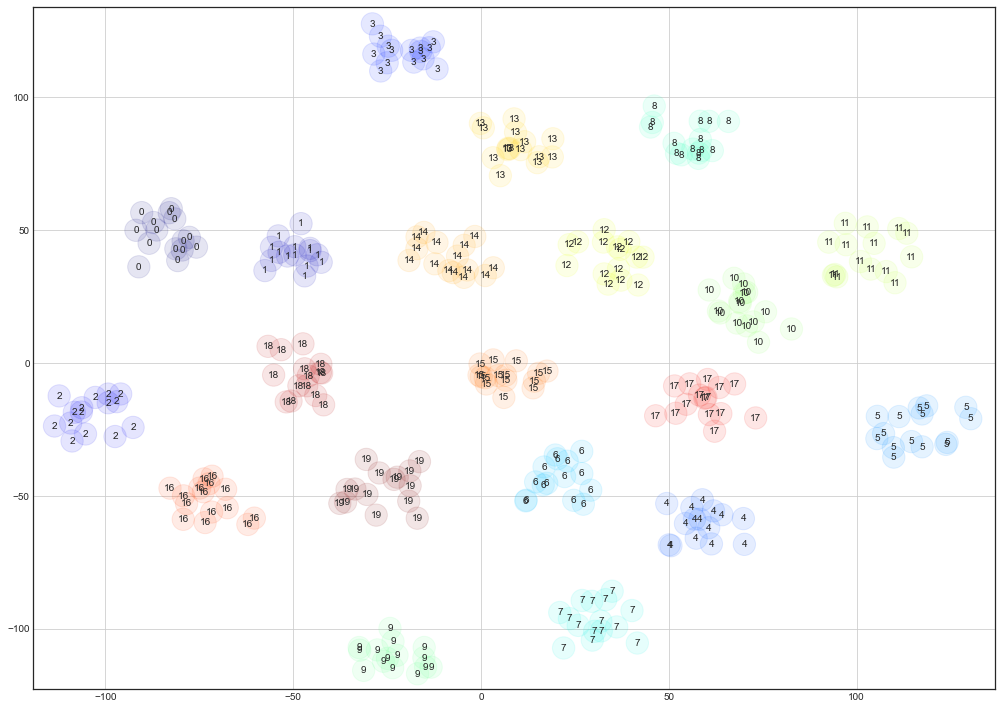

In [21]:
p2vmap.plot_tsne(tsne_map_xy, plotlabels=True, scatter=10)

<br>
<br>

## Data streamer

This is the basis for P2V in torch, we somehow need to "stream" our data (as batches) to the neural network.

### Data

In [22]:
baskets_2 = baskets.copy()
baskets_2 = baskets_2.head(1_000)
baskets_2 = baskets_2[baskets_2.groupby("basket")["product"].transform("nunique") > 2]
baskets_2.head()

,product,basket
0,51,00000000
1,113,00000000
2,154,00000000
3,165,00000000
4,185,00000000


In [23]:
baskets_2[baskets_2["basket"] == "00000000"]

,product,basket
0,51,00000000
1,113,00000000
2,154,00000000
3,165,00000000
4,185,00000000
5,253,00000000
6,266,00000000


### Initialize streamer

In [24]:
data_stream_p2v = p2vmap.DataStreamP2V(
    data=baskets_2,
    variable_basket="basket",
    variable_product="product",
    batch_size=4,  # in your implementation, you want higher batch sizes (e.g. 256, 512, 1024)
    shuffle=False,  # in your implementation, please shuffle!
    n_negative_samples=4,
)

### Generate one batch

In [25]:
center_products, context_products, negative_samples = data_stream_p2v.generate_batch()

In [26]:
# 4: A, B, C, D -> 12 samples
#
# sample 1: A -- B  --> 1 center product, 1 context product
# sample 2: A -- C
# sample 3: A -- D
# sample 4: B -- A
#     ...

In [27]:
# batch_size (x 1)
center_products

array([51, 51, 51, 51])

In [28]:
# batch_size (x 1)
context_products

array([113, 154, 165, 185])

In [29]:
# batch_size x 4
negative_samples

array([[142,  55, 263,  36],
       [ 31,  37,  62, 236],
       [114,  38, 226, 119],
       [158,  71, 190,  17]], dtype=int32)

<br>
<br>

## PyTorch

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/p2v.png" width="700">

### 1) generate indices

In [30]:
config_p2vmap["data"]["data_streamer"]

{'variable_basket': 'basket',
 'variable_product': 'product',
 'batch_size': 8192,
 'n_negative_samples': 10,
 'power': 0.75,
 'shuffle': False,
 'allow_context_collisions': False}

In [31]:
data_stream_p2v = p2vmap.DataStreamP2V(
    data=baskets_2, **config_p2vmap["data"]["data_streamer"]
)

In [32]:
config_p2vmap["data"]

{'data_streamer': {'variable_basket': 'basket',
  'variable_product': 'product',
  'batch_size': 8192,
  'n_negative_samples': 10,
  'power': 0.75,
  'shuffle': False,
  'allow_context_collisions': False},
 'split': {'test_size': 0.05},
 'train': {'batch_size': 1024, 'shuffle': True, 'drop_last': True},
 'valid': {'batch_size': 4096, 'shuffle': False, 'drop_last': False},
 'test': {'batch_size': 4096, 'shuffle': False, 'drop_last': False}}

In [33]:
# The data streamer was great, it generates our training samples
# torch does not use numpy arrays though, but torch tensors.
# also, torch offers its own functionality for streaming data, so
# we use our streamer to generate all training samples from the
# basket data, then put it into a torch data loader.
dl_train, dl_validation = p2vmap.build_data_loader(
    streamer=data_stream_p2v,
    config=config_p2vmap["data"],
)

In [34]:
for ce, co, ns in dl_train:
    ce, co, ns

In [35]:
ce, co, ns

(tensor([ 17, 256, 152,  ...,  37, 143, 279]),
 tensor([146, 110,   4,  ...,  47, 106,  90]),
 tensor([[196, 197, 194,  ...,  39, 276,  60],
         [ 15, 108, 248,  ..., 262, 145,  62],
         [ 30, 174, 100,  ..., 213, 201, 143],
         ...,
         [ 33, 198,  60,  ..., 116, 211, 134],
         [ 61,  27, 263,  ...,  69, 134,   1],
         [122, 206,  36,  ...,  42,  93, 172]]))

In [36]:
# see config_p2vmap["data"]["train"] and config_p2vmap["data"]["data_streamer"]
config_p2vmap["data"]["train"], config_p2vmap["data"]["data_streamer"]

({'batch_size': 1024, 'shuffle': True, 'drop_last': True},
 {'variable_basket': 'basket',
  'variable_product': 'product',
  'batch_size': 8192,
  'n_negative_samples': 10,
  'power': 0.75,
  'shuffle': False,
  'allow_context_collisions': False})

In [37]:
ce.shape, co.shape, ns.shape

(torch.Size([1024]), torch.Size([1024]), torch.Size([1024, 10]))

### 2) embed indices in vector space

Extract corresponding product vectors from embedding

In [38]:
wi = torch.nn.Embedding(product.shape[0], config_p2vmap["p2v"]["size"], sparse=True)  # input embedding
with torch.no_grad():
    wi.weight.uniform_(-0.025, 0.025)

wo = torch.nn.Embedding(product.shape[0], config_p2vmap["p2v"]["size"], sparse=True)  # output embedding
with torch.no_grad():
    wo.weight.uniform_(-0.025, 0.025)

In [39]:
# embed products (center, context, negative_samples)
# turns a product index (e.g., ce[0]) into a product vector (e.g., wi[ce[0]])
wi_center = wi(ce)
wo_positive_samples = wo(co)
wo_negative_samples = wo(ns)

In [40]:
wi_center.shape  # batch size x number of PV dimensions

torch.Size([1024, 25])

In [41]:
wo_positive_samples.shape  # batch size x number of PV dimensions

torch.Size([1024, 25])

In [42]:
wo_negative_samples.shape  # batch size x number of negatives samples x number of PV dimensions

torch.Size([1024, 10, 25])

In [43]:
wi_center[0]

tensor([ 0.0123,  0.0224, -0.0043,  0.0090, -0.0160, -0.0095,  0.0229, -0.0083,
        -0.0189, -0.0001,  0.0142,  0.0048, -0.0188,  0.0005, -0.0050, -0.0095,
         0.0143, -0.0190, -0.0204,  0.0132,  0.0165, -0.0071, -0.0013,  0.0137,
        -0.0184], grad_fn=<SelectBackward>)

In [44]:
wi.weight[ce[0]]  # ce[0] is the first center product in the data streamer output

tensor([ 0.0123,  0.0224, -0.0043,  0.0090, -0.0160, -0.0095,  0.0229, -0.0083,
        -0.0189, -0.0001,  0.0142,  0.0048, -0.0188,  0.0005, -0.0050, -0.0095,
         0.0143, -0.0190, -0.0204,  0.0132,  0.0165, -0.0071, -0.0013,  0.0137,
        -0.0184], grad_fn=<SelectBackward>)

In [45]:
ce[0]

tensor(17)

### 3) logits (aka scores)

In [46]:
logits_positive_samples = torch.einsum("ij,ij->i", (wi_center, wo_positive_samples))
logits_negative_samples = torch.einsum("ik,ijk->ij", (wi_center, wo_negative_samples))

### 4a) compute loss

We can compute the loss from probabilities or logits, logits is typically preferred (more robust computationally).

In [47]:
loss_positive_samples = torch.nn.functional.binary_cross_entropy_with_logits(
    input=logits_positive_samples,
    target=torch.ones_like(logits_positive_samples),
    reduction="sum",
)
loss_positive_samples

tensor(709.7798, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [48]:
loss_negative_samples = torch.nn.functional.binary_cross_entropy_with_logits(
    input=logits_negative_samples,
    target=torch.zeros_like(logits_negative_samples),
    reduction="sum",
)
loss_negative_samples

tensor(7097.8877, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

### 4b) average loss

In [49]:
n_samples = logits_positive_samples.shape[0] * (logits_negative_samples.shape[1] + 1)
n_samples

11264

In [50]:
(loss_positive_samples + loss_negative_samples) / n_samples

tensor(0.6932, grad_fn=<DivBackward0>)

<br>
<br>

## What's next?

### Build your model class

In [51]:
class P2V(torch.nn.Module):
    def __init__(self, n_products, size):
        """
        Init P2V model
        
        n_products: number of products in assortment
        size: number of latent dimensions in embedding
        """
        super().__init__()

        # add trainable variables here
        #   wi
        #   wo

    def forward(self, center, context, negative_samples):
        """
        P2V forward pass
        
        center: indices of center products (batch_size x 1)
        context: indices of context products (batch_size x 1)
        negative_samples: indices of negative samples (batch_size x n_negative_samples)
        
        input is output of iterating over data loader, e.g.,
        ```
        for ce, co, ns in self.train:
            loss_train = self.model(ce, co, ns)
            ...
        ```
        in `TrainerP2V` method `fit`. Here, `model` is an instance of this `P2V` class.
        """
        None

        # add forward pass here (steps 2-4)
        #   from indices ...
        #   ... to loss

### Build your trainer class

In [52]:
class TrainerP2V:
    def __init__(self, model, train, validation, path, n_batch_log=500):
        """
        Init P2V trainer
        
        model: the P2V module
        train: the train data loader (output of `p2vmap.build_data_loader`)
        validation: the validation data loader output of `p2vmap.build_data_loader`)
        path: absolute file path to write results to
        n_batch_log: call `self._callback_batch` every `n_batch_log` batches
        """
        self.model = model  # put your model here (via __init__ method)
        self.train = train
        self.validation = validation
        self.optimizer = torch.optim.SparseAdam(params=list(model.parameters()))
        self.path = path
        os.makedirs(f"{path}/weights")
        self.writer_train = torch.utils.tensorboard.SummaryWriter(
            f"{self.path}/runs/train"
        )
        self.writer_val = torch.utils.tensorboard.SummaryWriter(f"{self.path}/runs/val")
        self.n_batch_log = n_batch_log
        self.global_batch = 0
        self.epoch = 0
        self.batch = 0

    def fit(self, n_epochs):
        """
        Init P2V trainer
        
        n_epochs: number of epochs (i.e., iterations through complete data set)
        """

        for _ in range(n_epochs):
            print(f"epoch = {self.epoch}")

            for ce, co, ns in self.train:
                self.batch += 1
                self.global_batch += 1

                # add training steps here:
                #  - reset gradients
                #  - model (forward) pass
                #  - compute gradients
                #  - optimizer step

                self.writer_train.add_scalar("loss", loss_train, self.global_batch)

                if self.batch % self.n_batch_log == 1:
                    self._callback_batch()

            self._callback_epoch()
            self.epoch += 1

        self.writer_train.flush()
        self.writer_train.close()
        self.writer_val.flush()
        self.writer_val.close()

    def _callback_batch(self):
        # validation loss
        self.model.eval()
        with torch.no_grad():
            list_loss_validation = []
            for ce, co, ns in self.validation:
                list_loss_validation.append(self.model(ce, co, ns).item())
            loss_validation = np.mean(list_loss_validation)
        self.writer_val.add_scalar("loss", loss_validation, self.global_batch)
        self.model.train()

        # save weights
        np.save(
            f"{self.path}/weights/wi_{self.epoch:02d}_{self.batch:06d}.npy",
            self.get_wi(),
        )

        np.save(
            f"{self.path}/weights/wo_{self.epoch:02d}_{self.batch:06d}.npy",
            self.get_wo(),
        )

    def get_wi(self):
        return self.model.wi.weight.detach().numpy()

    def get_wo(self):
        return self.model.wo.weight.detach().numpy()

<br>
<br>
&mdash; <br>
Sebastian Gabel <br>
`Learning from Big Data`, Module 3, Extra Tutorial <br>
2021/22 <br>